Hello! Here you can find how to implement GNN and how to use it for RecSys.
We will recommend music to users
using [MAGNN architecture](https://arxiv.org/pdf/2002.01680.pdf) and [LastFM dataset](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.LastFM.html).
Specifically, the model will be used for "link prediction" task.

First of all, let's import everything for the work.

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.6 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import requests
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.datasets import LastFM

from sklearn.metrics import average_precision_score, roc_auc_score
from tqdm import tqdm

from collections import defaultdict

In [ ]:
np.random.seed(1337)
torch.manual_seed(1337)

In [ ]:
NUM_USERS = 1892
NUM_MOVIES = 17632
BATCH_SIZE = 64

num_user_features = 1
num_movie_features = 1

device = "cuda" if torch.cuda.is_available() else "cpu"

Let's extract the dataset and create a new feature for the it. We should do it to increase the accuracy of the model in the future.
The feature represents the similarity or closeness between the two users.

In [ ]:
# Loading features
def download_features(url, destination):
    if os.path.exists(destination):
        print('File already exists')
        return
    id = url.split('/')[-2]
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    with open(destination, "wb") as f:
        for chunk in response.iter_content(chunk_size = 32768):
            if chunk:
                f.write(chunk)

download_features('https://drive.google.com/file/d/10vW6OqHvIau0thmkoq84BWdzSPBPwUjc/view?usp=sharing', 'artist_artist(knn).dat')
download_features('https://drive.google.com/file/d/1lESwVMYH1tXHG5yW73DmVdiSmxRi_A5l/view?usp=sharing', 'user_user(knn).dat')

In [ ]:
# Loading initial dataset
dataset = LastFM("data/raw/LastFM")

# Loading preprocessed data
path = "./data/raw/LastFM/raw/"

# Extract features from dataset
user_sums = defaultdict(lambda: torch.tensor(0))
user_counts = defaultdict(lambda: torch.tensor(0))
with open("user_user(knn).dat") as f:
    for line in f:
        u1, _, w = map(float, line.split())
        u1 = int(u1)
        user_sums[u1] = user_sums[u1] + w
        user_counts[u1] += 1

movie_sums = defaultdict(lambda: torch.tensor(0))
movie_counts = defaultdict(lambda: torch.tensor(0))
with open("artist_artist(knn).dat") as f:
    for line in f:
        u1, _, w = map(float, line.split())
        u1 = int(u1)
        movie_sums[u1] = movie_sums[u1] + w
        movie_counts[u1] += 1

# Take average value
user_features = {i: (user_sums[i] / user_counts[i]).clone().detach() for i in user_sums}
movie_features = {i: (movie_sums[i] / movie_counts[i]).clone().detach() for i in movie_sums}

user_features = defaultdict(lambda: torch.tensor(0), user_features)
movie_features = defaultdict(lambda: torch.tensor(0), movie_features)


In [ ]:
dataset = dataset[0]

Now we will preprocess data and then split it to train and validation sets.

In [ ]:
edge_index = dataset["user", "to", "artist"]["edge_index"]
train_movie_metapaths = defaultdict(lambda: np.zeros(shape=(0, 3)))
for i in tqdm(edge_index[0].unique()):
    neighbors = torch.where((edge_index[0] == i).clone().detach(), edge_index, -1)[1].unique()[1:]
    comb = torch.combinations(neighbors, with_replacement=True)
    col = torch.ones(size=(comb.shape[0], 1)) * i
    meta_paths = torch.hstack((comb[:, :1], col, comb[:, 1:]))
    for path in meta_paths:
        train_movie_metapaths[int(path[0])] = np.vstack((train_movie_metapaths[int(path[0])], path))

100%|██████████| 1892/1892 [00:32<00:00, 57.71it/s]


In [ ]:
edge_index = dataset["user", "to", "artist"]["test_pos_edge_index"]
test_movie_metapaths = defaultdict(lambda: np.zeros(shape=(0, 3)))
for i in tqdm(edge_index[0].unique()):
    neighbors = torch.where((edge_index[0] == i).clone().detach(), edge_index, -1)[1].unique()[1:]
    comb = torch.combinations(neighbors, with_replacement=True)
    col = torch.ones(size=(comb.shape[0], 1)) * i
    meta_paths = torch.hstack((comb[:, :1], col, comb[:, 1:]))
    for path in meta_paths:
        test_movie_metapaths[int(path[0])] = np.vstack((test_movie_metapaths[int(path[0])], path))

100%|██████████| 1863/1863 [00:04<00:00, 465.42it/s]


In [ ]:
edge_index = dataset["artist", "to", "user"]["edge_index"]
train_user_metapaths = defaultdict(lambda: np.zeros(shape=(0, 3)))
for i in tqdm(edge_index[0].unique()):
    neighbors = torch.where((edge_index[0] == i).clone().detach(), edge_index, -1)[1].unique()[1:]
    comb = torch.combinations(neighbors, with_replacement=True)
    col = torch.ones(size=(comb.shape[0], 1)) * i
    meta_paths = torch.hstack((comb[:, :1], col, comb[:, 1:]))
    for path in meta_paths:
        train_user_metapaths[int(path[0])] = np.vstack((train_user_metapaths[int(path[0])], path))

100%|██████████| 17632/17632 [01:04<00:00, 274.61it/s]


In [ ]:
edge_index = dataset["user", "to", "artist"]["test_pos_edge_index"]
test_user_metapaths = defaultdict(lambda: np.zeros(shape=(0, 3)))
for i in tqdm(edge_index[1].unique()):
    neighbors = torch.where((edge_index[1] == i).clone().detach(), edge_index, -1)[0].unique()[1:]
    comb = torch.combinations(neighbors, with_replacement=True)
    col = torch.ones(size=(comb.shape[0], 1)) * i
    meta_paths = torch.hstack((comb[:, :1], col, comb[:, 1:]))
    for path in meta_paths:
        test_user_metapaths[int(path[0])] = np.vstack((test_user_metapaths[int(path[0])], path))

100%|██████████| 4041/4041 [00:08<00:00, 484.35it/s] 


In [ ]:
neg_edge_index = dataset["user", "to", "artist"]["train_neg_edge_index"]

train_pos = dataset["user", "to", "artist"]["edge_index"]
train_neg = neg_edge_index[:, :train_pos.shape[1]]

test_pos = dataset["user", "to", "artist"]["test_pos_edge_index"]
test_neg = dataset["user", "to", "artist"]["test_neg_edge_index"][:, :test_pos.shape[1]]

We also might need to do preprocess flow:

In [ ]:
class UserMovieDataset(Dataset):
    """Dataset for MAGNN training and evaluation"""

    def __init__(self, positives: torch.Tensor, user_meta_paths: defaultdict, movie_meta_paths: defaultdict,
                 max_user_size: int, max_movie_size: int, negatives=None, benchmark: bool = False):
        self.benchmark = benchmark
        self.max_user_size = max_user_size
        self.max_movie_size = max_movie_size

        self.user_meta_paths = user_meta_paths.copy()
        self.movie_meta_paths = movie_meta_paths.copy()
        self.merge_meta_paths()

        self.pos = positives.numpy()
        self.neg = negatives.numpy()

        self.data = torch.tensor(np.vstack([self.pos.T, self.neg.T]))
        self.labels = torch.vstack([torch.ones((len(self.pos.T), 1)), torch.zeros((len(self.neg.T), 1))])

    def merge_meta_paths(self):
        for key, val in tqdm(self.user_meta_paths.items(), desc="Extracting user meta-paths"):
            if len(self.user_meta_paths[key]) > 0:
                self.user_meta_paths[key] = [torch.vstack([user_features[i] for i in val[:, 0]])[:self.max_user_size],
                                             torch.vstack([movie_features[i] for i in val[:, 1]])[:self.max_user_size],
                                             torch.vstack([user_features[i] for i in val[:, 2]])[:self.max_user_size]]
                while len(self.user_meta_paths[key][0]) < self.max_user_size:
                    self.user_meta_paths[key][0] = torch.vstack(
                        [self.user_meta_paths[key][0], torch.zeros_like(self.user_meta_paths[key][0][0])])
                    self.user_meta_paths[key][1] = torch.vstack(
                        [self.user_meta_paths[key][1], torch.zeros_like(self.user_meta_paths[key][1][0])])
                    self.user_meta_paths[key][2] = torch.vstack(
                        [self.user_meta_paths[key][2], torch.zeros_like(self.user_meta_paths[key][2][0])])

        for key, val in tqdm(self.movie_meta_paths.items(), desc="Extracting movie meta-paths"):
            if len(self.movie_meta_paths[key]) > 0:
                self.movie_meta_paths[key] = [
                    torch.vstack([movie_features[i] for i in val[:, 0]])[:self.max_movie_size],
                    torch.vstack([user_features[i] for i in val[:, 1]])[:self.max_movie_size],
                    torch.vstack([movie_features[i] for i in val[:, 2]])[:self.max_movie_size]]
                while len(self.movie_meta_paths[key][0]) < self.max_movie_size:
                    self.movie_meta_paths[key][0] = torch.vstack(
                        [self.movie_meta_paths[key][0], torch.zeros_like(self.movie_meta_paths[key][0][0])])
                    self.movie_meta_paths[key][1] = torch.vstack(
                        [self.movie_meta_paths[key][1], torch.zeros_like(self.movie_meta_paths[key][1][0])])
                    self.movie_meta_paths[key][2] = torch.vstack(
                        [self.movie_meta_paths[key][2], torch.zeros_like(self.movie_meta_paths[key][2][0])])

    def __getitem__(self, idx):
        user_id, movie_id = self.data[idx]

        if len(self.user_meta_paths[user_id.item()]) == 0:
            key = user_id.item()
            self.user_meta_paths[key] = [torch.Tensor([0]), torch.Tensor([0]), torch.Tensor([0])]
            while len(self.user_meta_paths[key][0]) < self.max_user_size:
                self.user_meta_paths[key][0] = torch.vstack(
                    [self.user_meta_paths[key][0], torch.zeros_like(self.user_meta_paths[key][0][0])])
                self.user_meta_paths[key][1] = torch.vstack(
                    [self.user_meta_paths[key][1], torch.zeros_like(self.user_meta_paths[key][1][0])])
                self.user_meta_paths[key][2] = torch.vstack(
                    [self.user_meta_paths[key][2], torch.zeros_like(self.user_meta_paths[key][2][0])])

        if len(self.movie_meta_paths[movie_id.item()]) == 0:
            key = movie_id.item()
            self.movie_meta_paths[key] = [torch.Tensor([0]), torch.Tensor([0]), torch.Tensor([0])]
            while len(self.movie_meta_paths[key][0]) < self.max_movie_size:
                self.movie_meta_paths[key][0] = torch.vstack(
                    [self.movie_meta_paths[key][0], torch.zeros_like(self.movie_meta_paths[key][0][0])])
                self.movie_meta_paths[key][1] = torch.vstack(
                    [self.movie_meta_paths[key][1], torch.zeros_like(self.movie_meta_paths[key][1][0])])
                self.movie_meta_paths[key][2] = torch.vstack(
                    [self.movie_meta_paths[key][2], torch.zeros_like(self.movie_meta_paths[key][2][0])])

        return self.data[idx], self.labels[idx], *self.user_meta_paths[user_id.item()], *self.movie_meta_paths[
            movie_id.item()]

    def __len__(self):
        return len(self.data)

In [ ]:
print("Train Dataset:")
train_dataset = UserMovieDataset(train_pos, train_user_metapaths, train_movie_metapaths, 905, 67, train_neg)
print("Test Dataset:")
test_dataset = UserMovieDataset(test_pos, test_user_metapaths, test_movie_metapaths, 131, 28, test_neg, benchmark=True)

Train Dataset:


Extracting movie meta-paths: 100%|██████████| 17632/17632 [00:42<00:00, 417.96it/s]


Test Dataset:


Extracting movie meta-paths: 100%|██████████| 4041/4041 [00:04<00:00, 912.84it/s] 


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

So let's implement our model.
We will take a MAGNN for this data. It has many disadvantages:
- it can learn from multiple graphs simultaneously;
- it can model long-range dependencies that many common GNN cannot.

But there is also a disadvantage of the model: it's computationally expensive when we use datasets with a large number of nodes and edges. You will see it a bit later.
Let's look at the architecture closer.

---

## MAGNN workflow ##
Specifically, MAGNN first applies type-specific linear transformations to project heterogeneous node attributes, with possibly unequal dimensions for different node
types, to the same latent vector space. Next, MAGNN applies intra-metapath aggregation with the attention mechanism for every metapath.
During this intrametapath aggregation, each target node extracts and combines information from the metapath instances connecting the node with its metapath-based neighbors.
In this way, MAGNN captures the structural and semantic information of heterogeneous graphs from both neighbor nodes and the metapath context in between.
Following intra-metapath aggregation, MAGNN further conducts intermetapath aggregation using the attention mechanism to fuse latent vectors obtained from
multiple metapaths into final node embeddings. By integrating multiple metapaths, our model can learn the comprehensive semantics ingrained in the heterogeneous graph.

MAGNN is constructed by three major components: node content transformation, intra-metapath aggregation, and inter-metapath aggregation.
Here's an illustration of the embedding generation of a single node:
![](images/workflow.png)

In [ ]:
class GraphAttention(nn.Module):
    """Attention layer for encoded metapaths"""

    def __init__(self, hidden_dim: int, num_heads: int, dropout: float):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)

    def forward(self, x: torch.Tensor):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        weighted, _ = self.attention(queries, keys, values)
        return weighted


class MetapathEncoder(nn.Module):
    """Inter-metapath aggregator"""

    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)

    def forward(self, metapath):
        x = torch.mean(metapath, dim=1)
        return self.fc(x)


class MAGNN(nn.Module):
    """MAGNN architecture, but simplified for only 1 metapath per node type (due to computing powers limitation)"""

    def __init__(self, num_user_features: int, num_movie_features: int, hidden_dim: int, out_dim: int, num_heads: int, dropout: float, batch_size: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size

        self.num_user_features = num_user_features
        self.num_movie_features = num_movie_features

        self.user_feature_encoder = nn.Linear(self.num_user_features, hidden_dim)
        self.movie_feature_encoder = nn.Linear(self.num_movie_features, hidden_dim)

        self.user_metapath_encoder = MetapathEncoder(hidden_dim, hidden_dim)
        self.user_metapath_attention = GraphAttention(hidden_dim, num_heads, dropout)

        self.movie_metapath_encoder = MetapathEncoder(hidden_dim, hidden_dim)
        self.movie_metapath_attention = GraphAttention(hidden_dim, num_heads, dropout)

        self.user_node_embedding = nn.Linear(hidden_dim, out_dim)
        self.user_dropout = nn.Dropout(dropout)

        self.movie_node_embedding = nn.Linear(hidden_dim, out_dim)
        self.movie_dropout = nn.Dropout(dropout)

        self.recommender = nn.Linear(2 * out_dim, 1)

    def forward(self, _, user_metapaths1, user_metapaths2, user_metapaths3, movie_metapaths1, movie_metapaths2, movie_metapaths3):
        """
        Forward propagation of the model.

        You can find the pseudocode of the function in the paper that was mentioned in the beginning.
        """
        user_metapath_instance = torch.cat([
            self.user_feature_encoder(user_metapaths1),
            self.movie_feature_encoder(user_metapaths2),
            self.user_feature_encoder(user_metapaths3)
        ], dim=1)
        user_aggregated_metapath = F.tanh(self.user_metapath_encoder(user_metapath_instance))
        user_aggregated_metapath = self.user_metapath_attention(user_aggregated_metapath)

        movie_metapath_instance = torch.cat([
            self.movie_feature_encoder(movie_metapaths1),
            self.user_feature_encoder(movie_metapaths2),
            self.movie_feature_encoder(movie_metapaths3)
        ], dim=1)
        movie_aggregated_metapath = F.tanh(self.movie_metapath_encoder(movie_metapath_instance))
        movie_aggregated_metapath = self.movie_metapath_attention(movie_aggregated_metapath)

        user_embed = self.user_dropout(F.sigmoid(self.user_node_embedding(user_aggregated_metapath)))
        movie_embed = self.movie_dropout(F.sigmoid(self.movie_node_embedding(movie_aggregated_metapath)))

        return F.sigmoid(self.recommender(torch.cat([user_embed, movie_embed], dim=1)))

In [ ]:
model = MAGNN(num_user_features, num_movie_features, 128, 128, 8, 0.2, BATCH_SIZE)

To train the model we will use BCELoss and Adam optimizer. All settings you may see below.

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-7)

In [ ]:
def train(epoch: int):
    losses = []
    accs = []

    model.train()
    progress_bar = tqdm(train_loader, f"Epoch {epoch}")
    for batch in progress_bar:
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = batch
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = \
            edge.to(device), label.to(device), umetapath1.to(device), umetapath2.to(device), umetapath3.to(
                device), mmetapath1.to(device), mmetapath2.to(device), mmetapath3.to(device)

        optimizer.zero_grad()

        out = model(edge, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3)

        pred = (out > 0.5)

        loss = criterion(out, label)
        acc = (pred == label).sum() / BATCH_SIZE

        losses.append(loss.item())
        accs.append(acc.cpu())

        loss.backward()
        optimizer.step()

        progress_bar.set_description(f"Epoch {epoch}, Loss: {np.mean(losses):.5f}, Acc: {np.mean(accs):.5f}")

    return np.mean(losses)


def validate(epoch: int):
    losses = []
    accs = []

    model.eval()
    progress_bar = tqdm(test_loader)
    for batch in progress_bar:
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = batch
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = \
            edge.to(device), label.to(device), umetapath1.to(device), umetapath2.to(device), umetapath3.to(
                device), mmetapath1.to(device), mmetapath2.to(device), mmetapath3.to(device)

        out = model(edge, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3)

        pred = (out > 0.5)

        loss = criterion(out, label)
        acc = (pred == label).sum() / BATCH_SIZE

        losses.append(loss.item())
        accs.append(acc.cpu())

        progress_bar.set_description(f"Validation Epoch {epoch}, Loss: {np.mean(losses):.5f}, Acc: {np.mean(accs):.5f}")

    return np.mean(losses)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
EPOCHS = 50
train_losses = []
val_losses = []
best_loss = float("inf")
model.to(device)
for epoch in range(EPOCHS):
    train_loss = train(epoch)
    val_loss = validate(epoch)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print()
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_magnn.pt")

Validation Epoch 0, Loss: 0.46512, Acc: 0.84378: 100%|██████████| 581/581 [00:05<00:00, 106.23it/s]


Validation Epoch 1, Loss: 0.46331, Acc: 0.84297: 100%|██████████| 581/581 [00:05<00:00, 112.41it/s]


Validation Epoch 2, Loss: 0.45473, Acc: 0.84526: 100%|██████████| 581/581 [00:06<00:00, 96.05it/s]


Validation Epoch 3, Loss: 0.46037, Acc: 0.84316: 100%|██████████| 581/581 [00:06<00:00, 92.56it/s]


Validation Epoch 4, Loss: 0.44880, Acc: 0.84515: 100%|██████████| 581/581 [00:05<00:00, 105.00it/s]


Validation Epoch 5, Loss: 0.44542, Acc: 0.84760: 100%|██████████| 581/581 [00:05<00:00, 106.93it/s]


Validation Epoch 6, Loss: 0.43663, Acc: 0.84703: 100%|██████████| 581/581 [00:06<00:00, 93.43it/s]


Validation Epoch 7, Loss: 0.42776, Acc: 0.84827: 100%|██████████| 581/581 [00:05<00:00, 109.21it/s]


Validation Epoch 8, Loss: 0.43921, Acc: 0.84442: 100%|██████████| 581/581 [00:05<00:00, 110.76it/s]


Validation Epoch 9, Loss: 0.42889, Acc: 0.84934: 100%|██████████| 581/581 [00:06<00:00, 95.53it/s]


Validation Epoch 10, Loss: 0.43261, Acc: 0.84907: 100%|██████████| 581/581 [00:05<00:00, 112.31it/s]


Validation Epoch 11, Loss: 0.43668, Acc: 0.84789: 100%|██████████| 581/581 [00:05<00:00, 111.28it/s]


Validation Epoch 12, Loss: 0.43511, Acc: 0.84851: 100%|██████████| 581/581 [00:06<00:00, 96.43it/s]


Validation Epoch 13, Loss: 0.43725, Acc: 0.84679: 100%|██████████| 581/581 [00:05<00:00, 111.53it/s]


Validation Epoch 14, Loss: 0.42883, Acc: 0.84889: 100%|██████████| 581/581 [00:05<00:00, 107.93it/s]


Validation Epoch 15, Loss: 0.43875, Acc: 0.84499: 100%|██████████| 581/581 [00:05<00:00, 100.65it/s]


Validation Epoch 16, Loss: 0.44789, Acc: 0.84044: 100%|██████████| 581/581 [00:05<00:00, 110.98it/s]


Validation Epoch 17, Loss: 0.44393, Acc: 0.84160: 100%|██████████| 581/581 [00:05<00:00, 97.01it/s]


Validation Epoch 18, Loss: 0.43770, Acc: 0.84273: 100%|██████████| 581/581 [00:05<00:00, 108.90it/s]


Validation Epoch 19, Loss: 0.44085, Acc: 0.83985: 100%|██████████| 581/581 [00:05<00:00, 109.31it/s]


Validation Epoch 20, Loss: 0.42443, Acc: 0.84846: 100%|██████████| 581/581 [00:06<00:00, 94.50it/s]


Validation Epoch 21, Loss: 0.42842, Acc: 0.84854: 100%|██████████| 581/581 [00:05<00:00, 111.75it/s]


Validation Epoch 22, Loss: 0.43373, Acc: 0.84488: 100%|██████████| 581/581 [00:05<00:00, 112.78it/s]


Validation Epoch 23, Loss: 0.43495, Acc: 0.84485: 100%|██████████| 581/581 [00:06<00:00, 95.73it/s]


Validation Epoch 24, Loss: 0.42945, Acc: 0.84275: 100%|██████████| 581/581 [00:05<00:00, 111.75it/s]


Validation Epoch 25, Loss: 0.41961, Acc: 0.84827: 100%|██████████| 581/581 [00:05<00:00, 103.13it/s]


Validation Epoch 26, Loss: 0.43282, Acc: 0.84189: 100%|██████████| 581/581 [00:05<00:00, 100.02it/s]


Validation Epoch 27, Loss: 0.43181, Acc: 0.84587: 100%|██████████| 581/581 [00:05<00:00, 110.43it/s]


Validation Epoch 28, Loss: 0.44312, Acc: 0.83522: 100%|██████████| 581/581 [00:05<00:00, 98.45it/s]


Validation Epoch 29, Loss: 0.42513, Acc: 0.84426: 100%|██████████| 581/581 [00:05<00:00, 104.59it/s]


Validation Epoch 30, Loss: 0.42462, Acc: 0.84526: 100%|██████████| 581/581 [00:05<00:00, 111.63it/s]


Validation Epoch 31, Loss: 0.43090, Acc: 0.84028: 100%|██████████| 581/581 [00:06<00:00, 95.36it/s] 


Validation Epoch 32, Loss: 0.42482, Acc: 0.84657: 100%|██████████| 581/581 [00:05<00:00, 110.52it/s]


Validation Epoch 33, Loss: 0.43292, Acc: 0.83945: 100%|██████████| 581/581 [00:05<00:00, 103.08it/s]


Validation Epoch 34, Loss: 0.42904, Acc: 0.83808: 100%|██████████| 581/581 [00:05<00:00, 98.70it/s]


Validation Epoch 35, Loss: 0.41751, Acc: 0.84450: 100%|██████████| 581/581 [00:05<00:00, 111.18it/s]


Validation Epoch 36, Loss: 0.42144, Acc: 0.84461: 100%|██████████| 581/581 [00:06<00:00, 94.55it/s]


Validation Epoch 37, Loss: 0.43081, Acc: 0.83840: 100%|██████████| 581/581 [00:05<00:00, 108.11it/s]


Validation Epoch 38, Loss: 0.42198, Acc: 0.84308: 100%|██████████| 581/581 [00:05<00:00, 108.12it/s]


Validation Epoch 39, Loss: 0.42871, Acc: 0.84327: 100%|██████████| 581/581 [00:05<00:00, 98.78it/s]


Validation Epoch 40, Loss: 0.43664, Acc: 0.83611: 100%|██████████| 581/581 [00:05<00:00, 104.26it/s]


Validation Epoch 41, Loss: 0.43110, Acc: 0.83670: 100%|██████████| 581/581 [00:05<00:00, 110.16it/s]


Validation Epoch 42, Loss: 0.42217, Acc: 0.84219: 100%|██████████| 581/581 [00:06<00:00, 96.60it/s]


Validation Epoch 43, Loss: 0.42739, Acc: 0.84071: 100%|██████████| 581/581 [00:05<00:00, 109.02it/s]


Validation Epoch 44, Loss: 0.42611, Acc: 0.84316: 100%|██████████| 581/581 [00:05<00:00, 98.90it/s]


Validation Epoch 45, Loss: 0.42881, Acc: 0.84047: 100%|██████████| 581/581 [00:05<00:00, 111.55it/s]


Validation Epoch 46, Loss: 0.42613, Acc: 0.83953: 100%|██████████| 581/581 [00:05<00:00, 110.29it/s]


Validation Epoch 47, Loss: 0.42253, Acc: 0.84367: 100%|██████████| 581/581 [00:06<00:00, 94.84it/s]


Validation Epoch 48, Loss: 0.42184, Acc: 0.84163: 100%|██████████| 581/581 [00:05<00:00, 108.87it/s]


Validation Epoch 49, Loss: 0.42282, Acc: 0.84133: 100%|██████████| 581/581 [00:05<00:00, 103.83it/s]

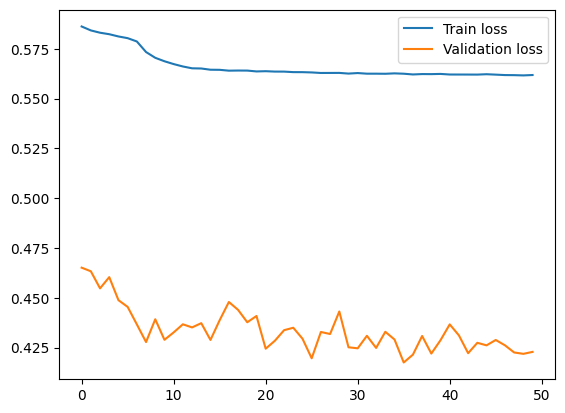

In [ ]:
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.show()

In [ ]:
model = MAGNN(num_user_features, num_movie_features, 128, 128, 8, 0.2, BATCH_SIZE)
model.load_state_dict(torch.load("best_magnn.pt"))

<All keys matched successfully>

In [ ]:
model.to(device)
model.eval()

maps = []
accs = []
rocs = []

for batch in tqdm(test_loader):
    edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = batch
    edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = \
        edge.to(device), label.to(device), umetapath1.to(device), umetapath2.to(device), umetapath3.to(
            device), mmetapath1.to(device), mmetapath2.to(device), mmetapath3.to(device)

    out = model(edge, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3)
    pred = (out > 0.5)
    acc = (pred == label.reshape(-1, 1)).sum() / BATCH_SIZE

    accs.append(acc.cpu())
    maps.append(average_precision_score(label.reshape(-1, 1).cpu().detach().numpy(), out.cpu().detach().numpy()))
    rocs.append(roc_auc_score(label.reshape(-1, 1).cpu().detach().numpy(), out.cpu().detach().numpy()))

print(f"mAP: {np.mean(maps)}")
print(f"Accuracy: {np.mean(accs)}")
print(f"ROC-AUC score: {np.mean(rocs)}")

100%|██████████| 581/581 [00:04<00:00, 141.85it/s]

mAP: 0.9339975937438384
Accuracy: 0.8444223403930664
ROC-AUC score: 0.9507799327758307
